In [1]:
from datetime import datetime
import json
import os
import subprocess

import numpy as np
from matplotlib import pyplot as plt
# matplotlib configuration
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"

from solver._internal.config.config import required_modes as REQUIRED_ALGORITHMS
from solver._internal.config.config import additional_modes as ADDITIONAL_ALGORITHMS
from solver._internal.utils.testutils import REAL_PUZZLES

In [2]:
class Puzzle:
    def __init__(self, puzzle, min_num_steps):
        self.puzzle        = puzzle
        self.min_num_steps = min_num_steps

class Solution:
    def __init__(self, algorithm, puzzle, num_steps, num_expanded_states, elapsed_time):
        self.algorithm           = algorithm
        self.optimal             = puzzle.min_num_steps
        self.actual              = num_steps
        self.num_expanded_states = num_expanded_states
        self.elapsed_time        = elapsed_time

In [3]:
def run_program_timed(algorithm, puzzle_entries):
    before = datetime.now()
    output = subprocess.run(['./TP1', algorithm, *[str(entry) for entry in puzzle_entries], 'PRINT_STATISTICS'], capture_output=True)
    elapsed = datetime.now() - before
    return output.stdout.decode('ascii'), elapsed

def decode_program_output(output):
    output_pieces = [piece for piece in output.strip().split('\n') if piece != '']
    num_steps_to_goal, json_num_expanded_states = output_pieces
    num_expanded_states = json.loads(json_num_expanded_states)['num_expanded_states']
    
    if num_steps_to_goal == 'Solution not found.':
        num_steps_to_goal = None
    else:
        num_steps_to_goal = int(num_steps_to_goal)

    return num_steps_to_goal, num_expanded_states

def compute_all_solutions(algorithms):
    solutions = []
    for puzzle_idx in range(len(REAL_PUZZLES[:25])):
        puzzle = REAL_PUZZLES[puzzle_idx]

        for algorithm in algorithms:
            output, elapsed_time = run_program_timed(algorithm, puzzle)
            num_steps_to_goal, num_expanded_states = decode_program_output(output)
            solutions.append(Solution(algorithm, Puzzle(puzzle, puzzle_idx), num_steps_to_goal, num_expanded_states, elapsed_time))
    return solutions

def format_time(t):
    return round(t / 10**6, 6)

def build_time_map(solutions):
    time_map = {}
    for solution in solutions:
        algorithm = solution.algorithm
        if algorithm not in time_map:
            time_map[algorithm] = []
        time_map[algorithm].append(format_time(solution.elapsed_time.microseconds))
    return time_map

def build_cost_map(solutions):
    cost_map = {}
    for solution in solutions:
        algorithm = solution.algorithm
        if algorithm not in cost_map:
            cost_map[algorithm] = []
        cost_map[algorithm].append(solution.num_expanded_states)
    return cost_map

def build_numsteps_map(solutions):
    numsteps_map = {}
    for solution in solutions:
        algorithm = solution.algorithm
        if algorithm not in numsteps_map:
            numsteps_map[algorithm] = []
        numsteps_map[algorithm].append(solution.actual)
    return numsteps_map

def plot_solution_not_found(main_map, numsteps_map, algorithm):
    numsteps = np.array(numsteps_map[algorithm])
    mask = numsteps == None
    x = np.array(range(len(numsteps)))[mask]
    y = np.array(main_map[algorithm])[mask]
    if len(y) > 0:
        print(f"Length of y for algorithm {algorithm} is greater than zero")
        plt.scatter(x, y, label="Solution not found", marker='x', c='brown', s=100, linewidth=3)

def draw_and_save_solutions(times_map, cost_map, numsteps_map, save_plot_figures=False, figure_out_dir="results/figures"):
    plt.figure()
    plt.xlabel("Puzzle difficulty")
    plt.ylabel("Time elapsed")
    plt.title(f'Time performance comparison')
    for algorithm in times_map:
        y = times_map[algorithm]
        x = list(range(len(y)))
        plt.plot(x, y, label=algorithm, linewidth=3)

        plt.legend()
        if save_plot_figures:
            os.system(f"mkdir -p {figure_out_dir}")
            plt.savefig(f"{figure_out_dir}/perf_analysis_time.png")
            
    plt.figure()
    plt.xlabel("Puzzle difficulty")
    plt.ylabel("Number of expanded states")
    plt.title(f'Cost comparison')
    for algorithm in cost_map:
        y = cost_map[algorithm]
        x = list(range(len(y)))
        plt.plot(x, y, label=algorithm, linewidth=3)
        
        plt.legend()
        if save_plot_figures:
            os.system(f"mkdir -p {figure_out_dir}")
            plt.savefig(f"{figure_out_dir}/perf_analysis_num_expanded_states.png")
            
            
    plt.figure()
    plt.xlabel("Puzzle difficulty")
    plt.ylabel("Number of steps in solution")
    plt.title(f'Solution quality comparison')
    for algorithm in numsteps_map:
        y = numsteps_map[algorithm]
        x = list(range(len(y)))
        plt.plot(x, y, label=algorithm, linewidth=3)

        plt.legend()
        if save_plot_figures:
            os.system(f"mkdir -p {figure_out_dir}")
            plt.savefig(f"{figure_out_dir}/perf_analysis_num_steps.png")

In [4]:
solutions = compute_all_solutions(REQUIRED_ALGORITHMS)

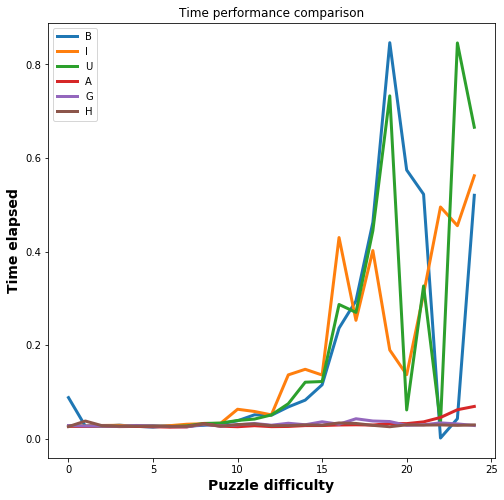

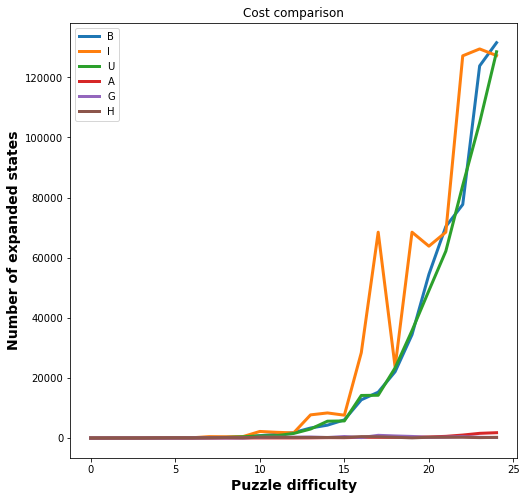

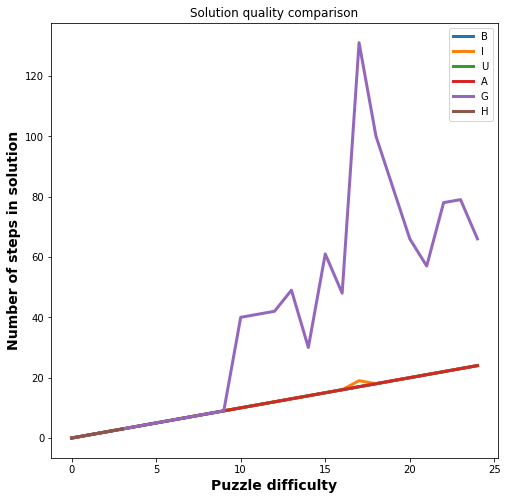

In [5]:
times_map = build_time_map(solutions)
num_expanded_states_map = build_cost_map(solutions)
numsteps_map = build_numsteps_map(solutions)
draw_and_save_solutions(times_map, num_expanded_states_map, numsteps_map, save_plot_figures=True, figure_out_dir='results/figures-required-algos')

In [6]:
solutions = compute_all_solutions(ADDITIONAL_ALGORITHMS)

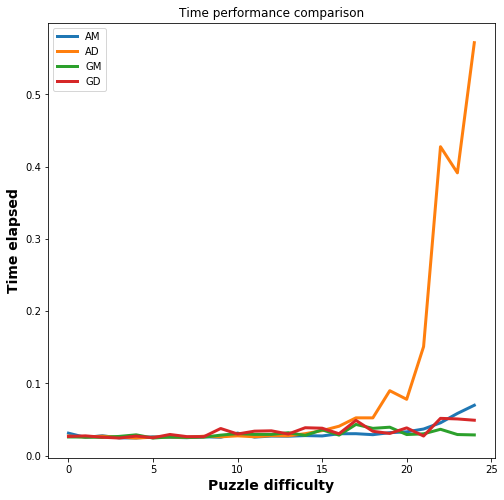

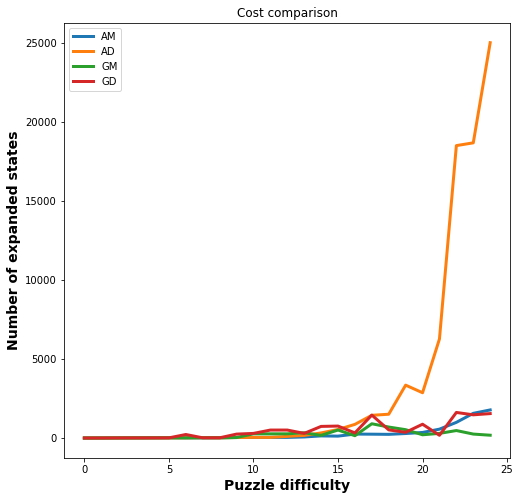

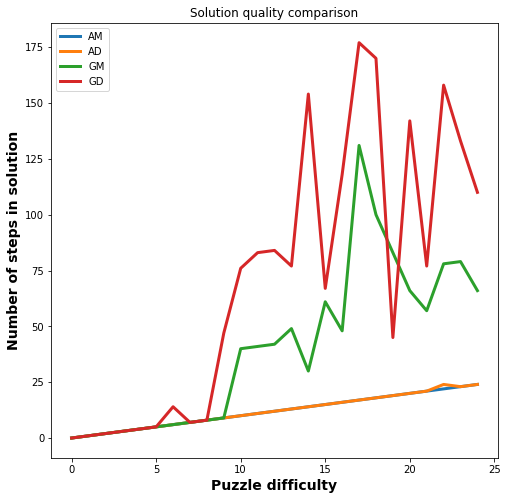

In [7]:
times_map = build_time_map(solutions)
num_expanded_states_map = build_cost_map(solutions)
numsteps_map = build_numsteps_map(solutions)
draw_and_save_solutions(times_map, num_expanded_states_map, numsteps_map, save_plot_figures=True, figure_out_dir='results/figures-additional-algos')